> Bradley Treeby, Antonio Stanziola

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
import jwave
from jwave.geometry import kGrid, Medium
from jwave.matlab import Matlab
from jwave.physics import solve_helmholtz
from jax import numpy as jnp
import numpy as np
import k3d

# Setup in MATLAB script
The geometric quantities, acoustic properties and sources are computed using the script `_matlab/skull_setup.m`

In [45]:
!pygmentize -O style=paraiso-light _matlab/skull_setup.m

% Script to define a geometry to run in JAX
%
% author: Bradley Treeby
% date: 13 February 2021
% last update: 5 March 2021 (Antonio Stanziola)

% add other toolboxes to the path
addpath('/mnt/Software/k-Plan/toolbox/');
addpath('/mnt/Software/k-Plan/libraries/nifti/');

% =========================================================================
% LITERALS
% =========================================================================

% source properties
source_f0       = 200e3;    % [Hz]
source_mag      = 40e3;     % [Pa]
bowl_roc        = 64e-3;    % bowl radius of curvature [m]
bowl_diameter   = 64e-3;    % bowl aperture diameter [m]

% source position
source_pos      = [-0.07, -0.08];     % [m]
focus_pos       = [0.025, 0.03];           % [m]

% image properties
img_slice_idx   = 80;   
img_scale       = 1;

% =========================================================================
% LOAD SKULL AND SETUP GRID
% =========================================================================

---
The script can be run using the `run_script()` method of the matlab interface.

In [4]:
mlb = Matlab()
mlb.start()

Opening new matlab session


In [5]:
mlb.run("clearvars")
mlb.add('/home/astanziola/repos/jwaverepo/docs/examples/_data/CT.nii', "ct_location")

The following code assumes a `nii` CT file located in the path specified by the `ct_location` variable in the MATLAB workspace. The file must contain a single 2D CT image of size 128x128.

Make sure to change the path in the next cell to the correct one.

In [6]:
mlb.add('/home/astanziola/repos/jwaverepo/docs/examples/_data/CT.nii', "ct_location")

In [7]:
mlb.run_script("_matlab/skull_setup.m")

# Ground truth simulation

In [8]:
from jax import numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Assign variables from MATLAB workspace (which exists as a Python dictionary)
Nx = int(mlb.get("Nx"))
Ny = int(mlb.get("Ny"))
dx = float(mlb.get("dx"))
dy = float(mlb.get("dy"))
omega = float(mlb.get("omega"))
sound_speed = jnp.asarray(mlb.get("sound_speed"))
attenuation = jnp.asarray(mlb.get("attenuation"))/1e3 # ???
src_field = jnp.asarray(mlb.get("p_mask"))#/(dx**2)
skull_mask = jnp.asarray(mlb.get("skull_mask"), dtype=float)
brain_mask = jnp.asarray(mlb.get("brain_mask"), dtype=float)

# Close matlab
mlb.stop()

# Print grid size
print("Nx={}, Ny={}".format(Nx, Ny))

# Create grid
N = (Nx, Ny)
d = (dx, dy)
grid = kGrid.make_grid(N, d)

Nx=128, Ny=128


In [10]:
mlb.stop() # Quitting matlab

In [11]:
# Create geometry using fully heterogeneous skull
ref_medium = Medium(
    sound_speed=sound_speed,
    density=1.,
    attenuation=attenuation,
    pml_size=15
)

(-0.5, 127.5, 127.5, -0.5)

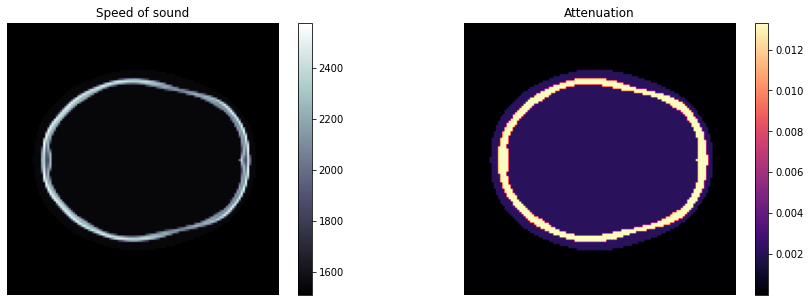

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
im = ax[0].imshow(sound_speed, cmap="bone")
plt.colorbar(im, ax=ax[0])
ax[0].set_title("Speed of sound")
ax[0].axis('off')

im = ax[1].imshow(attenuation, cmap="magma")
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Attenuation")
ax[1].axis('off')

In [13]:
def field_from_medium(m):
    return solve_helmholtz(grid, m, src_field, omega, tol=1e-5)

In [14]:
# get the reference solution
ref_field = field_from_medium(ref_medium)

Text(0.5, 1.0, 'Masked Field')

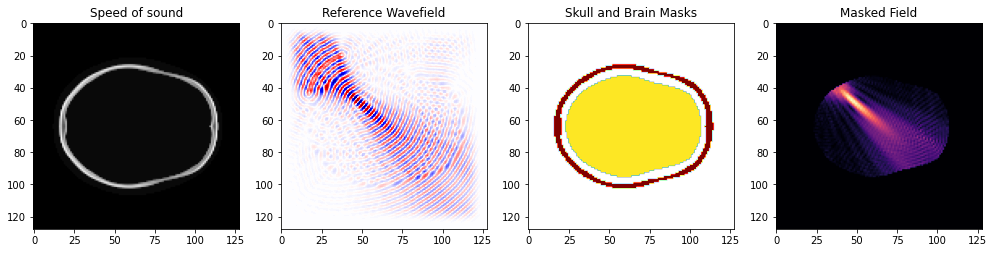

In [15]:
fig, axes = plt.subplots(1,4,figsize=(17,12))

axes[0].imshow(ref_medium.sound_speed, cmap="gray")
axes[0].set_title("Speed of sound")

axes[1].imshow(jnp.real(ref_field), cmap="seismic")
axes[1].set_title("Reference Wavefield")

axes[2].imshow(skull_mask, cmap="jet", alpha=skull_mask)
axes[2].imshow(brain_mask, cmap="viridis", alpha=brain_mask)
axes[2].set_title("Skull and Brain Masks")

axes[3].imshow(brain_mask * jnp.abs(ref_field), cmap="magma")
axes[3].set_title("Masked Field")

In [16]:
from jax.experimental import optimizers
from jax import jit
from tqdm import tqdm

from functools import partial
import jax

from jax import value_and_grad, vmap

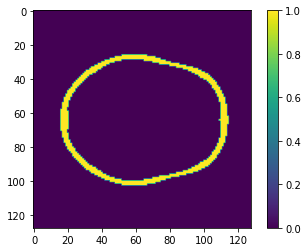

In [17]:
plt.imshow(skull_mask)
plt.colorbar()

Automatic differentiation allows us to write arbitrarily complex loss function, as long as they're continous and differentiable everywhere except for a non measureble set of points (e.g. $|x|$ is subdifferentiable)

In [ ]:
def get_sound_speed(x):
    return ref_medium.sound_speed[10,10] + 1500*jax.nn.sigmoid(x)*skull_mask

def loss(speed_of_sound):
    #return jnp.sqrt(jnp.sum(jnp.abs(field - ref_field)))
    medium = Medium(
        sound_speed=speed_of_sound,
        density=1.,
        attenuation=ref_medium.attenuation,
        pml_size=15
    )
    field = field_from_medium(medium)
    return jnp.sum(jnp.abs(jnp.abs(field)-jnp.abs(ref_field))*brain_mask), field

def full_loss(x):
    sos = get_sound_speed(x)
    return loss(sos)

In [23]:
# Random key
key = jax.random.PRNGKey(42)

# test and compiles the functions
homog_sos = jnp.zeros(N)
test_loss_value, initial_field = full_loss(homog_sos)

In [24]:
print("Initial loss value", test_loss_value)

Initial loss value 125.587845


(-0.5, 127.5, 127.5, -0.5)

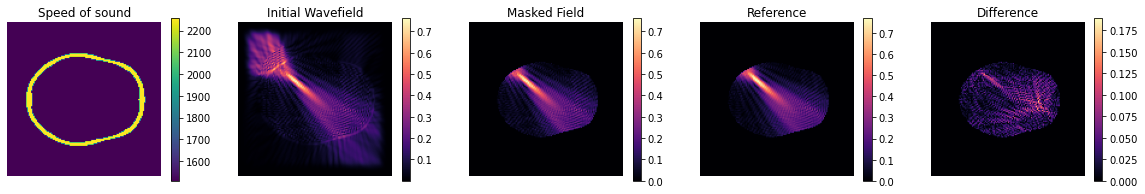

In [25]:
fig, axes = plt.subplots(1,5,figsize=(20,3))

im = axes[0].imshow(get_sound_speed(homog_sos))
axes[0].set_title("Speed of sound")
plt.colorbar(im, ax=axes[0])
axes[0].axis('off')

im = axes[1].imshow(jnp.abs(initial_field), cmap="magma")
axes[1].set_title("Initial Wavefield")
plt.colorbar(im, ax=axes[1])
axes[1].axis('off')

im = axes[2].imshow(brain_mask * jnp.abs(initial_field), cmap="magma")
axes[2].set_title("Masked Field")
plt.colorbar(im, ax=axes[2])
axes[2].axis('off')

im = axes[3].imshow(brain_mask * jnp.abs(ref_field), cmap="magma")
axes[3].set_title("Reference")
plt.colorbar(im, ax=axes[3])
axes[3].axis('off')

im = axes[4].imshow(jnp.abs(brain_mask * jnp.abs(ref_field) - brain_mask * jnp.abs(initial_field)), cmap="magma")
axes[4].set_title("Difference")
plt.colorbar(im, ax=axes[4])
axes[4].axis('off')

In [29]:
# takes the computational graph needed to calculate the loss function (full_loss)
# and returns a new function that calculates the loss and the gradient of the function
# wrt the input (in this case the first input of full_loss which is homog_sos).
# has_aux ignores the extra things returns by full_loss.
loss_with_grad = value_and_grad(full_loss, has_aux=True)

# optimisers have a state, and an update function which gives you the next prediction
# get_params: gives you the parameters (in this case homog_sos) given the current state
init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.5, b2=0.5)

# calls init_fun to initialise the state of the optimiser
opt_state = init_fun(homog_sos)

# the @partial command applies the jit command to the update function
# the static_argnums sets tol as a static argument
#@partial(jit, static_argnums=(1,))
def update(opt_state, tol, field, key):
    
    # loss_and_field: outputs of full_loss
    # gradient: gradient of loss wrt homog_sos
    loss_and_field, gradient = loss_with_grad(get_params(opt_state))
    
    # splitting loss_and_field
    lossval = loss_and_field[0]
    field = loss_and_field[1]
    
    # return the loss, the field, and call the update function (e.g., to take a gradient descent step)
    return lossval, field, update_fun(k, gradient, opt_state)

# initialisation
tol = 1e-4
losshistory = []
field = initial_field

# progress bar, 100 sets the length of the for loop
pbar = tqdm(range(100))

# Initializing random seed
key = jax.random.PRNGKey(1234)

# looping from [0, 1000)
for k in pbar:
    key, subkey = jax.random.split(key)
    
    # take an update step
    lossval, field, opt_state = update(opt_state, tol, field, subkey)
    
    # Smooth loss
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.5*avg_loss + 0.5*lossval
        
    # reduce the tolerance
    if lossval > avg_loss and k > 20:
        tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Tol: {} | Avg. loss: {:01.4f} | loss: {:01.4f}".format(tol, avg_loss, lossval))
    losshistory.append(lossval)


Tol: 1e-05 | Avg. loss: 62.2926 | loss: 62.4458: 100%|██████████| 100/100 [11:00<00:00,  6.61s/it] 


Text(0.5, 1.0, 'Loss')

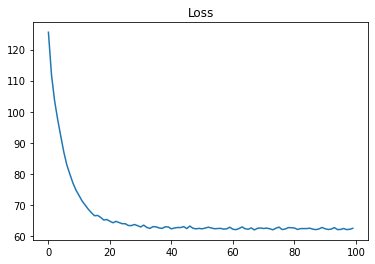

In [30]:
plt.plot(losshistory)
plt.title("Loss")

(-0.5, 127.5, 127.5, -0.5)

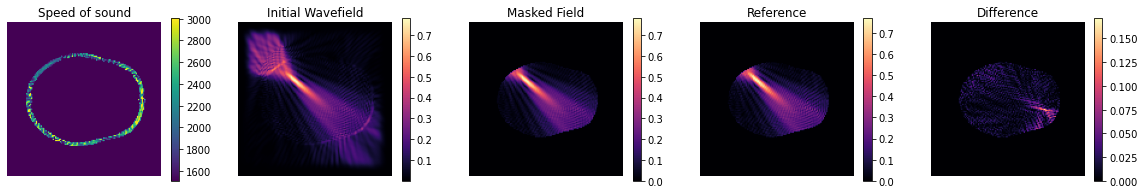

In [31]:
opt_homog_sos = get_params(opt_state)


fig, axes = plt.subplots(1,5,figsize=(20,3))

im = axes[0].imshow(get_sound_speed(opt_homog_sos))
axes[0].set_title("Speed of sound")
plt.colorbar(im, ax=axes[0])
axes[0].axis('off')

im = axes[1].imshow(jnp.abs(field), cmap="magma")
axes[1].set_title("Initial Wavefield")
plt.colorbar(im, ax=axes[1])
axes[1].axis('off')

im = axes[2].imshow(brain_mask * jnp.abs(field), cmap="magma")
axes[2].set_title("Masked Field")
plt.colorbar(im, ax=axes[2])
axes[2].axis('off')

im = axes[3].imshow(brain_mask * jnp.abs(ref_field), cmap="magma")
axes[3].set_title("Reference")
plt.colorbar(im, ax=axes[3])
axes[3].axis('off')

im = axes[4].imshow(jnp.abs(brain_mask * jnp.abs(ref_field) - brain_mask * jnp.abs(field)), cmap="magma")
axes[4].set_title("Difference")
plt.colorbar(im, ax=axes[4])
axes[4].axis('off')